In [6]:
import torch
# Changed pipeline import to StableDiffusionXLControlNetPipeline
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoPipelineForImage2Image
from diffusers.utils import load_image
from PIL import Image
import numpy as np
import cv2

print("Loading Depth ControlNet model...")
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0", # Depth ControlNet model
    torch_dtype=torch.float16,
    variant="fp16", 
    use_safetensors=True
)
print("ControlNet model loaded.")


print("Pipeline loaded and moved to GPU.")

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    torch_dtype = torch.float16,
    variant = "fp16",

    use_safetensors=True
)

# Enable memory optimizations
pipeline.enable_model_cpu_offload() # Offload parts to CPU to save VRAM
pipeline.enable_xformers_memory_efficient_attention() # Use if xformers is installed





Loading Depth ControlNet model...
ControlNet model loaded.
Pipeline loaded and moved to GPU.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
def preprocess_img(url, res: tuple[int, int] = (1024, 1024)):
    """Preprocesses the input image: Load, Grayscale, Resize, CLAHE, Denoise, Sharpen, Convert to RGB."""
    kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

    try:
        # Load image, convert to grayscale, resize
        img = Image.open(url).convert("L").resize((res), Image.LANCZOS)
    except FileNotFoundError:
        print(f"Error: Image file not found at {url}")
        return None
    except Exception as e:
        print(f"Error opening or processing image: {e}")
        return None
        
    img_np = np.array(img)

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_img = clahe.apply(img_np)

    # Denoise the image first
    denoised_img = cv2.fastNlMeansDenoising(contrast_img, h=7) # Denoising strength
    
    # Sharpen the denoised image
    sharpened_img = cv2.filter2D(denoised_img, -1, kernel) 

    final = Image.fromarray(sharpened_img)
    # Convert final grayscale image to RGB for the pipeline input
    return final.convert("RGB")

def txt2img_depth_controlnet( 
    control_image_url, # URL of the image providing depth structure
    prompt=(
        "A photo of a bald cute newborn baby, closed eyes, sad." 
        
    ),
    negative_prompt="Hair, fabric, fingers, ugly, disgusting, uncanny",
    guidance=8, # Guidance scale (tune this)
    controlnet_conditioning_scale=0.6, # ControlNet strength (tune this!)
    num_inference_steps=20, # Number of diffusion steps
    height=1024, # Output image height
    width=1024,  # Output image width
):
    """Generates an image from text prompt using Depth ControlNet for structure."""
    print("Preprocessing control image...")
    # Preprocess the ultrasound image to use as the ControlNet conditioning image
    control_image = preprocess_img(control_image_url, res=(height, width)) 
    print(type(control_image))
    if type(control_image) is None:
        return None # Exit if preprocessing failed
    
    print("Using preprocessed image as depth conditioning map.")

    print("Running text-to-image inference pipeline...")
    # Call the StableDiffusionXLControlNetPipeline
    # Note: We DO NOT pass the 'image' parameter anymore.
    # Generation starts from noise, guided by prompt and control_image.
    output_image = pipeline(
            image = Image.open(control_image_url).resize((1024, 1024), Image.LANCZOS),
            prompt=prompt,
            negative_prompt=negative_prompt,
            control_image=control_image, # The ultrasound image providing depth structure
            guidance_scale=guidance,
            controlnet_conditioning_scale=controlnet_conditioning_scale, 
            num_inference_steps=num_inference_steps,
            height=height, # Specify output height
            width=width,   # Specify output width
        ).images[0]
    print("Inference complete.")
    return output_image


In [7]:
torch.cuda.empty_cache()

Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/16 [00:00<?, ?it/s]

Inference complete.


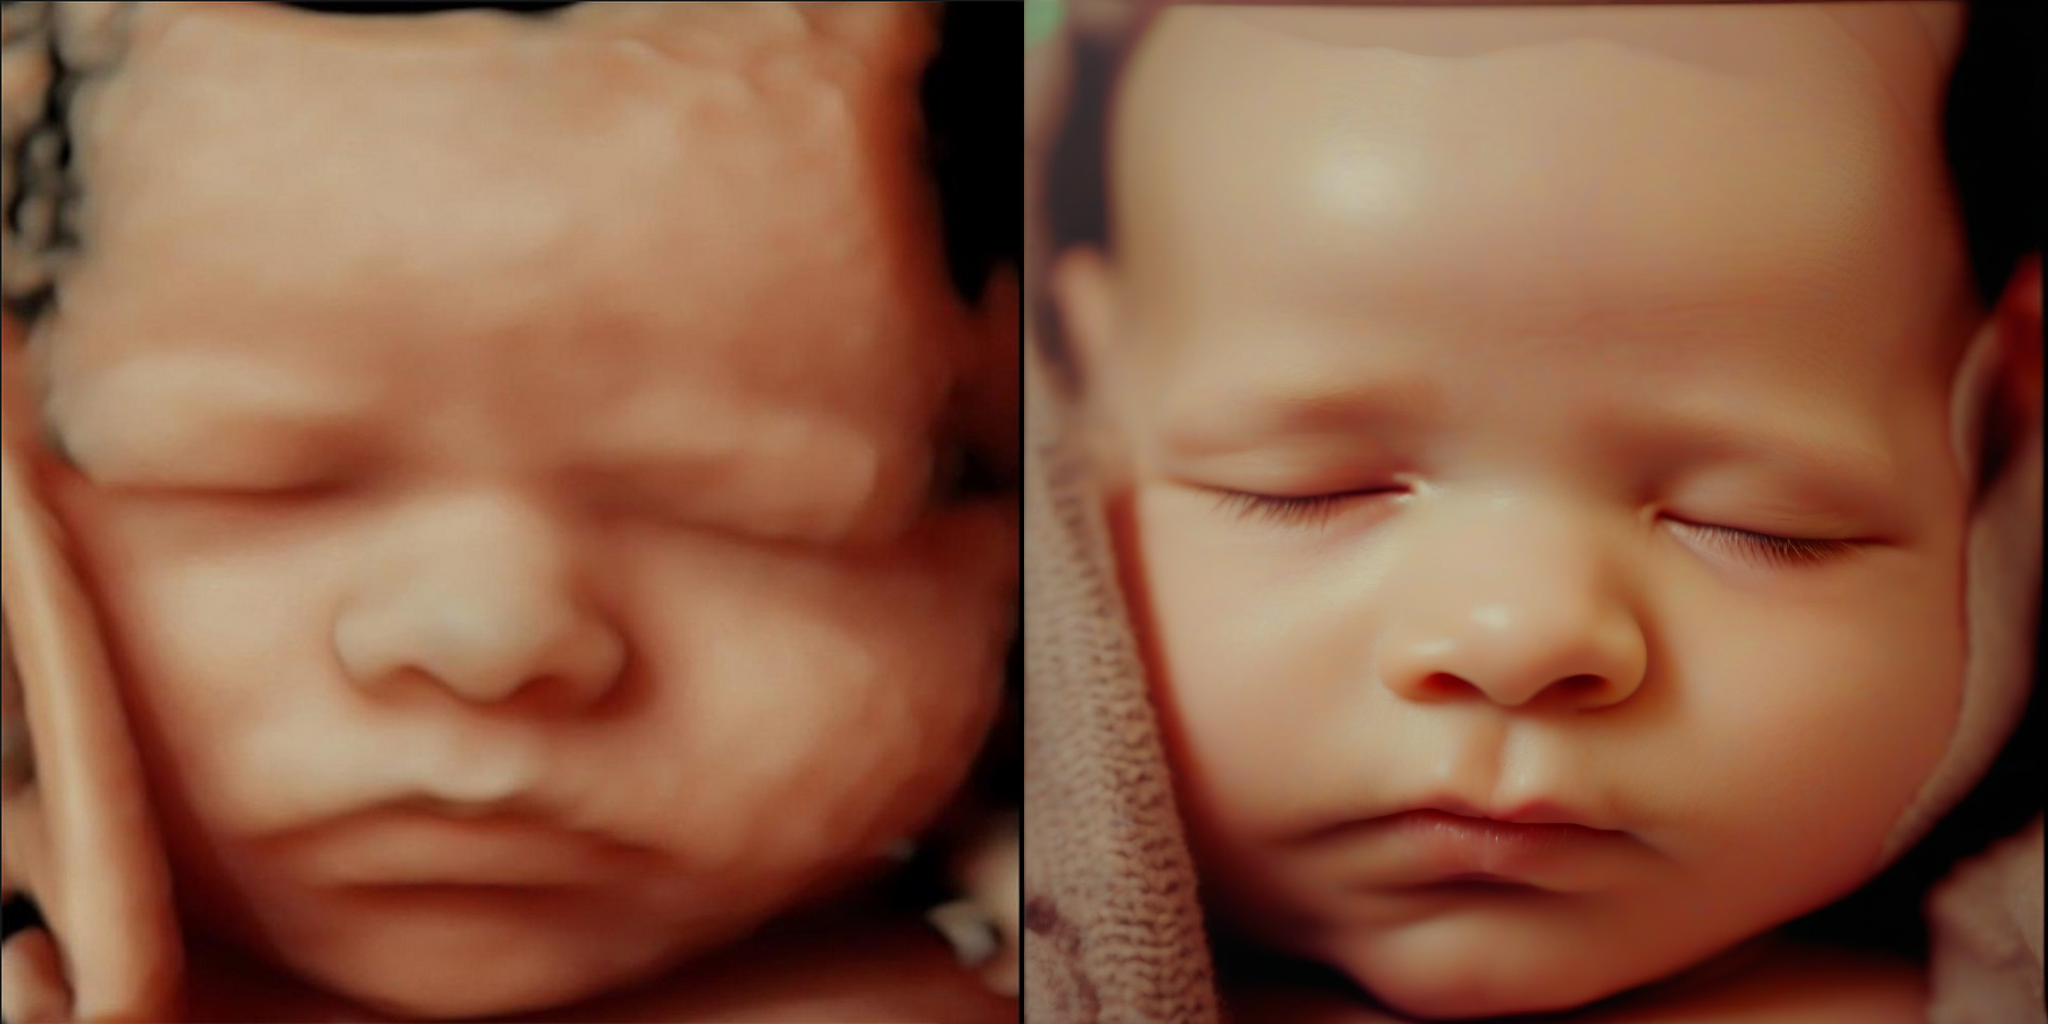

In [8]:
url = "./imgs/test2.png" 
from diffusers.utils import make_image_grid


original = Image.open(url).resize((1024, 1024), Image.LANCZOS) 
output_image = txt2img_depth_controlnet(control_image_url=url) 


make_image_grid([original, output_image], rows=1, cols=2)

Preprocessing control image...
<class 'PIL.Image.Image'>
Using preprocessed image as depth conditioning map.
Running text-to-image inference pipeline...


  0%|          | 0/20 [00:00<?, ?it/s]

Inference complete.


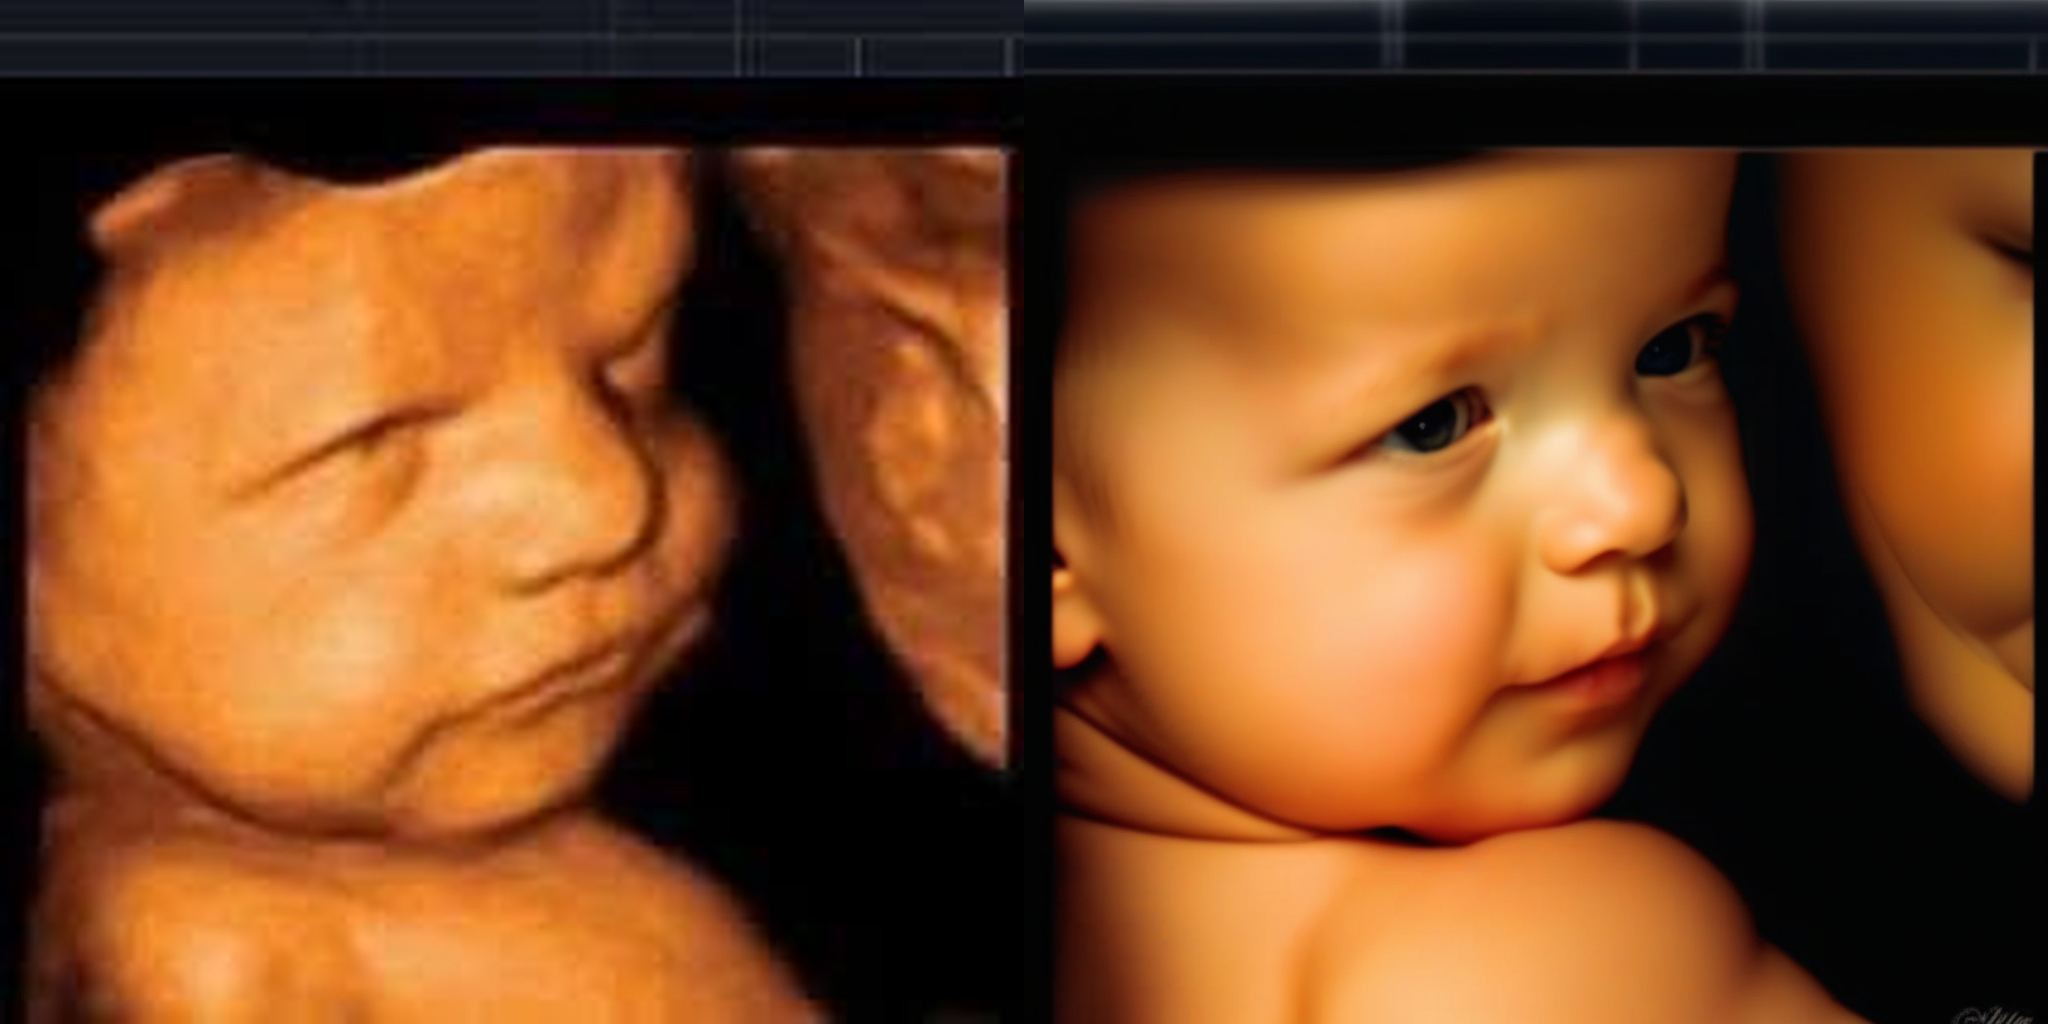

In [12]:
url = "./imgs/finaltest.jpeg" 
from diffusers.utils import make_image_grid


original = Image.open(url).resize((1024, 1024), Image.LANCZOS) 
output_image = txt2img_depth_controlnet(
    control_image_url=url,
    prompt="Beautiful bald baby",
    controlnet_conditioning_scale=.7,
    guidance= 10.5,
    num_inference_steps=25
    ) 


make_image_grid([original, output_image], rows=1, cols=2)

In [2]:
from diffusers.utils import make_image_grid    
def infer(url):


    original = Image.open(url).resize((1024, 1024), Image.LANCZOS) 
    output_image = txt2img_depth_controlnet(
        control_image_url=url,
        #prompt="Beautiful bald baby",
        controlnet_conditioning_scale=.7,
        guidance= 10.5,
        num_inference_steps=25
        ) 

    return output_image
   

In [4]:
import gradio as gr
demo = gr.Interface(
    fn=infer,
    inputs=[
        gr.Image(label="Input Image"),  # image input
    ],
    outputs=gr.Image(label="Output Image"),
    title="Stable Diffusion XL Image-to-Image Demo",
   
)

In [5]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/home/yahir-luna/miniconda3/envs/Ultra3d/lib/python3.11/site-packages/PIL/Image.py", line 3511, in open
    fp.seek(0)
    ^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yahir-luna/miniconda3/envs/Ultra3d/lib/python3.11/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yahir-luna/miniconda3/envs/Ultra3d/lib/python3.11/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yahir-luna/miniconda3/envs/Ultra3d/lib/python3.11/site-packages/gradio/blocks.py", line 2137, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^